## Question C
Increase the number of neurons.  Plot the test error of the best trained linear models with increasing number of neurons.  You can experiment with different network sizes.  Plot the test error with respect to the neurons.


In [2]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Finished iteration: 1
Finished iteration: 2
Finished iteration: 3
Finished iteration: 4
Finished iteration: 5
Finished iteration: 6
Finished iteration: 7
Finished iteration: 8
Finished iteration: 9
Finished iteration: 10
Finished iteration: 11
Finished iteration: 12
Finished iteration: 13
Finished iteration: 14
Finished iteration: 15
Finished iteration: 16
Finished iteration: 17
Finished iteration: 18
Finished iteration: 19
Finished iteration: 20
Finished iteration: 21
Finished iteration: 22
Finished iteration: 23
Finished iteration: 24
Finished iteration: 25
Finished iteration: 26
Finished iteration: 27
Finished iteration: 28
Finished iteration: 29
Finished iteration: 30


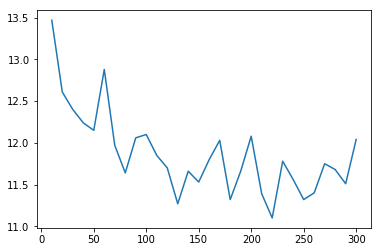

In [26]:
numPixels = 784
firstLayerOutput = 10
numClassifications = 10

numNeurons = []
testErrors = []


for i in range(1, 31):
    tf.reset_default_graph()
    # Initial input
    x = tf.placeholder(tf.float32, [None, numPixels])
    # Reference
    ref = tf.placeholder(tf.float32, [None, numClassifications])

    logits1 = tf.layers.dense(inputs=x, units=firstLayerOutput * i, activation=None, name="L1")
    logits2 = tf.layers.dense(inputs=logits1, units=numClassifications, activation=None, name="L2")

    # Calculate the cross entropy, doing the softmax function internally
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits2, labels=ref)

    # Take the average of the cross entropy values
    cost = tf.reduce_mean(cross_entropy)

    # (N). Take the highest percentile value in the prediction as the answer
    prediction = tf.argmax(tf.nn.softmax(logits2), axis=1)

    labels = []
    for label in mnist.test.labels:
        labels.append(np.argmax(label))
    labels = np.array(labels)

    rate = 0.01
    epochs = 100
    iterationsPerEpoch = 10
    
    optimizer = tf.train.GradientDescentOptimizer(rate).minimize(cost)
    s = tf.Session()
    s.run(tf.global_variables_initializer())
    for _ in range(epochs):
        inputData, correctAns = mnist.train.next_batch(100)
        validationInput, validationCorrect = mnist.train.next_batch(100)
        for _ in range(iterationsPerEpoch):
            # Do the training
            err, _ = s.run((cost, optimizer), feed_dict={x: inputData, ref: correctAns})

    # Check the test error
    predic = s.run((prediction), feed_dict={x: mnist.test.images})
    answers = np.equal(labels, predic)
    corrGuesses = np.sum(answers)
    testErr = corrGuesses / len(answers)   
    
    numNeurons.append(i * firstLayerOutput)
    testErrors.append((1 - testErr) * 100)
    
    print("Finished iteration: " + str(i))

plt.plot(numNeurons, testErrors)
plt.show()

It would appear that generally as the number of neurons increases, the test error decreases to an extent until the amount of training from the neurons causing an overfitting error. Thus after a certain number of neurons, it actually starts to decrease the accuracy of the test error.